# Linear Regression (OG)

Import statement below necessary for all three diff models!!

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

extract features

In [ ]:
data = pd.read_csv('merged_data.csv')
data['EFFECTIVE_DATE'] = pd.to_datetime(data['effective_date'])
data['STARTMARKETINGDATE'] = pd.to_datetime(data['STARTMARKETINGDATE'], format='%Y%m%d', errors='coerce')

# add days on market
data['DAYS_ON_MARKET'] = (data['EFFECTIVE_DATE'] - data['STARTMARKETINGDATE']).dt.days
data['DAYS_ON_MARKET'] = data['DAYS_ON_MARKET'].fillna(0)
data['DAYS_ON_MARKET'] = data['DAYS_ON_MARKET'].apply(lambda x: x if x >= 0 else 0)
data['year'] = data['STARTMARKETINGDATE'].dt.year

# log transformation
data['nadac_per_unit_log'] = np.log1p(data['nadac_per_unit'])
y = data['nadac_per_unit_log'].fillna(0)

features = [
    'pricing_unit', 'otc', 'classification_for_rate_setting', 'corresponding_generic_drug_nadac_per_unit',
    'year', 'package_size', 'units_reimbursed', 'number_of_prescriptions', 'PRODUCTTYPENAME',
    'ROUTENAME', 'MARKETINGCATEGORYNAME', 'total_amount_reimbursed', 'medicaid_amount_reimbursed',
    'non_medicaid_amount_reimbursed', 'DAYS_ON_MARKET'
]
X = data[features].copy()

Code for extracting info & metrics from model

In [ ]:
def calculate_feature_importance(X, y, model): # calculate important
    coefficients = model.coef_[0]
    n = X.shape[0]
    p = X.shape[1]

    y_pred = model.predict(X)
    mse = np.sum((y - y_pred) ** 2) / (n - p)

    X_mean = X - np.mean(X, axis=0)
    var_covar_matrix = np.linalg.pinv(X_mean.T.dot(X_mean)) * mse

    p_values = 2 * (1 - stats.t.cdf(abs(t_stats), n - p))

    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': coefficients,
        'P_Value': p_values,
        'Abs_Coefficient': np.abs(coefficients)
    })

    return feature_importance

clean up features

In [ ]:
# clean up features
X['otc'] = X['otc'].map({'Y': 1, 'N': 0})
X['corresponding_generic_drug_nadac_per_unit'] = np.where(
    X['corresponding_generic_drug_nadac_per_unit'].notna() &
    (X['corresponding_generic_drug_nadac_per_unit'] != ''),
    1, 0
)
numerical_cols = [
    'year', 'package_size', 'units_reimbursed', 'number_of_prescriptions',
    'total_amount_reimbursed', 'medicaid_amount_reimbursed',
    'non_medicaid_amount_reimbursed', 'DAYS_ON_MARKET'
]
for col in numerical_cols:
    X[col] = X[col].fillna(X[col].median())

categorical_cols = [
    'pricing_unit',
    'classification_for_rate_setting',
    'PRODUCTTYPENAME',
    'ROUTENAME',
    'MARKETINGCATEGORYNAME'
]
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# default missing values
X = X.fillna(0)


split and run OLS

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

Evaluate model

In [ ]:
feature_importance = calculate_feature_importance(X_train, y_train, model)

pd.set_option('display.float_format', lambda x: '%.2e' % x if abs(x) < 0.01 else '%.5f' % x)

print("\nTop 5 Most Important Features (by coefficient magnitude):")
print(feature_importance[['Feature', 'Coefficient', 'P_Value', 'T_Statistic']].head().to_string())

plt.figure(figsize=(12, 6))
plt.title('Top 10 Feature Coefficients (Absolute Values)')
plt.bar(feature_importance['Feature'].head(10), feature_importance['Abs_Coefficient'].head(10))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

y_pred = model.predict(X_test)

# back to original scale
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

mse_original = mean_squared_error(y_test_original, y_pred_original)
r2_original = r2_score(y_test_original, y_pred_original)
print(f"MSE on original scale: {mse_original:.4f}")
print(f"R-squared on original scale: {r2_original:.4f}")

# visualizations
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.plot(
    [y_test_original.min(), y_test_original.max()],
    [y_test_original.min(), y_test_original.max()],
    'r--', label='Perfect Prediction'
)
plt.xlabel('Real Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs. Actual Prices on Original Scale')
plt.legend()
plt.show()

# Pre/Post August 2022 Linear Regression



For splitting the dataset in terms of before August 2022 and after August 2022

Load and prepare data

In [ ]:
data = pd.read_csv('merged_data.csv')

data['EFFECTIVE_DATE'] = pd.to_datetime(data['effective_date'])
data['STARTMARKETINGDATE'] = pd.to_datetime(data['STARTMARKETINGDATE'], format='%Y%m%d', errors='coerce')

data['DAYS_ON_MARKET'] = (data['EFFECTIVE_DATE'] - data['STARTMARKETINGDATE']).dt.days
data['DAYS_ON_MARKET'] = data['DAYS_ON_MARKET'].fillna(0)
data['DAYS_ON_MARKET'] = data['DAYS_ON_MARKET'].apply(lambda x: x if x >= 0 else 0)

data['year'] = data['STARTMARKETINGDATE'].dt.year

data['nadac_per_unit_log'] = np.log1p(data['nadac_per_unit'])
y = data['nadac_per_unit_log'].fillna(0)

Grab features

In [ ]:
features = [
    'pricing_unit', 'otc', 'classification_for_rate_setting', 'corresponding_generic_drug_nadac_per_unit',
    'year', 'package_size', 'units_reimbursed', 'number_of_prescriptions', 'PRODUCTTYPENAME',
    'ROUTENAME', 'MARKETINGCATEGORYNAME', 'total_amount_reimbursed', 'medicaid_amount_reimbursed',
    'non_medicaid_amount_reimbursed', 'DAYS_ON_MARKET'
]

X = data[features].copy()

Clean features

In [ ]:
X['otc'] = X['otc'].map({'Y': 1, 'N': 0})
X['corresponding_generic_drug_nadac_per_unit'] = np.where(
    X['corresponding_generic_drug_nadac_per_unit'].notna() &
    (X['corresponding_generic_drug_nadac_per_unit'] != ''),
    1, 0
)

numerical_cols = [
    'year', 'package_size', 'units_reimbursed', 'number_of_prescriptions',
    'total_amount_reimbursed', 'medicaid_amount_reimbursed',
    'non_medicaid_amount_reimbursed', 'DAYS_ON_MARKET'
]

categorical_cols = [
    'pricing_unit',
    'classification_for_rate_setting',
    'PRODUCTTYPENAME',
    'ROUTENAME',
    'MARKETINGCATEGORYNAME'
]

for col in numerical_cols:
    X[col] = X[col].fillna(X[col].median())

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X = X.fillna(0)

Split data based on pre - post August 2022

In [ ]:
cutoff_date = pd.to_datetime('2022-08-01')

before_mask = data['EFFECTIVE_DATE'] < cutoff_date
X_before = X[before_mask].copy()
y_before = y[before_mask]
X_after = X[~before_mask].copy()
y_after = y[~before_mask]

print(f"Size of dataset before Aug 2022: {X_before.shape[0]}")
print(f"Size of dataset after Aug 2022: {X_after.shape[0]}")

In [ ]:
def analyze_dataset(X, y, dataset_name):  # run model and analysis on model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # this is still on log scale
    mse_log = mean_squared_error(y_test, y_pred)
    r2_log = r2_score(y_test, y_pred)

    # transform back to original scale
    y_pred_original = np.expm1(y_pred)
    y_test_original = np.expm1(y_test)
    mse_original = mean_squared_error(y_test_original, y_pred_original)
    r2_original = r2_score(y_test_original, y_pred_original)

    feature_stats = calculate_feature_importance(X_train, y_train, model)
    print(f"MSE (original scale): {mse_original:.4f}")
    print(f"R² (original scale): {r2_original:.4f}")

    print("\nTop 5 Features by Statistical Significance:")
    print(feature_stats.sort_values('P_Value')[
        ['Feature', 'Coefficient', 'T_Statistic', 'P_Value']
    ].head().to_string())
    return model, feature_stats

Run code and analysis on both datasets

In [ ]:
# Analyze both datasets
model_before, stats_before = analyze_dataset(X_before, y_before, "Data Before August 2022")
model_after, stats_after = analyze_dataset(X_after, y_after, "Data From August 2022 Onwards")

# Compare feature importance changes
feature_comparison = pd.merge(
    stats_before[['Feature', 'Coefficient', 'P_Value']].rename(
        columns={'Coefficient': 'Coef_Before', 'P_Value': 'P_Before'}
    ),
    stats_after[['Feature', 'Coefficient', 'P_Value']].rename(
        columns={'Coefficient': 'Coef_After', 'P_Value': 'P_After'}
    ),
    on='Feature'
)

feature_comparison['Coefficient_Change'] = feature_comparison['Coef_After'] - feature_comparison['Coef_Before']
feature_comparison['Abs_Change'] = abs(feature_comparison['Coefficient_Change'])

print("\nTop 10 Features with Largest Changes:")
print(feature_comparison.sort_values('Abs_Change', ascending=False).head(10).to_string())

# Linear Regression with PCA

Load dataset

In [ ]:
data = pd.read_csv('features_PCA.csv')

In [ ]:
monetary_features = [
    'total_amount_reimbursed',
    'medicaid_amount_reimbursed',
    'non_medicaid_amount_reimbursed'
]

Group the different features incl. the embeddings

In [ ]:
count_features = [
    'units_reimbursed',
    'number_of_prescriptions'
]

binary_features = [
    'otc',
    'classification_for_rate_G'
]

embedding_features = {
    'substance': [col for col in data.columns if col.startswith('SUBSTANCENAME_')],
    'epc': [col for col in data.columns if col.startswith('EPCembed_')],
    'cs': [col for col in data.columns if col.startswith('CSembed_')],
    'pe': [col for col in data.columns if col.startswith('PEembed_')],
    'moa': [col for col in data.columns if col.startswith('MoAembed_')],
    'ext': [col for col in data.columns if col.startswith('EXTembed_')]
}

X = data[monetary_features + ['pricing'] + count_features + binary_features +
         embedding_features['substance'] + embedding_features['epc'] +
         embedding_features['cs'] + embedding_features['pe'] +
         embedding_features['moa'] + embedding_features['ext']].copy()

Transform the monetary features and count features separately bc they are very large and cause issues -- log transform

In [ ]:
for col in monetary_features:
    X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)

for col in count_features:
    X[col] = np.log1p(X[col])

One-hot encode the pricing columns

In [ ]:
X = pd.get_dummies(X, columns=['pricing'], drop_first=True)

Split data, then scale using StandardScaler

In [ ]:
y = np.log1p(data['nadac_per_unit'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler_numeric = StandardScaler()
features_to_scale = monetary_features + count_features
X_train_scaled[features_to_scale] = scaler_numeric.fit_transform(X_train[features_to_scale])
X_test_scaled[features_to_scale] = scaler_numeric.transform(X_test[features_to_scale])

Fit model

In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

Evaluate model


Model Performance:
--------------------------------------------------
Log Scale:
MSE: 0.3456
R²: 0.6961
RMSE: 0.5878

Original Scale:
MSE: 99222.5743
R²: 0.0365
RMSE: 314.9961

Top 20 Most Important Features:
                            Feature  Coefficient
6         classification_for_rate_G    -1.195446
1        medicaid_amount_reimbursed     1.140925
3                  units_reimbursed    -0.787820
0           total_amount_reimbursed    -0.448540
2    non_medicaid_amount_reimbursed     0.331603
128                      pricing_ML     0.221494
4           number_of_prescriptions    -0.173840
5                               otc     0.141335
87                       MoAembed_0    -0.096095
30                       EPCembed_3     0.085515
39                      EPCembed_12    -0.074703
32                       EPCembed_5     0.071723
89                       MoAembed_2     0.071167
44                      EPCembed_17    -0.068911
14                  SUBSTANCENAME_7     0.060943
88    

<ipython-input-2-368a48dcb820>:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='red')
<ipython-input-2-368a48dcb820>:157: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test_original.min(), y_test_original.max()],


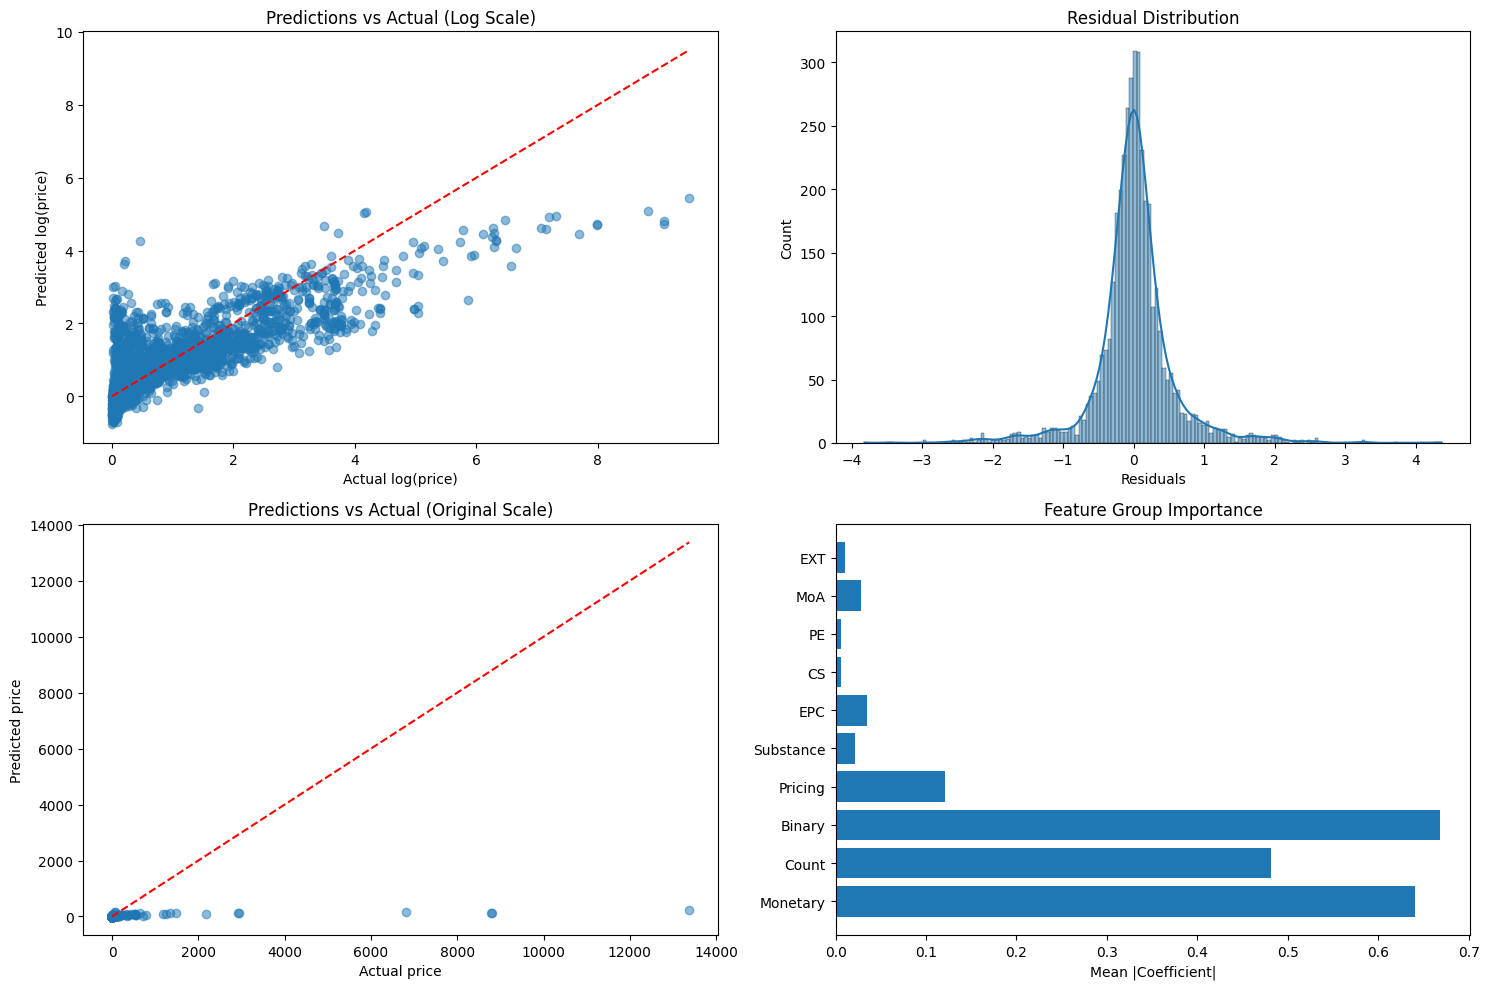

In [ ]:

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# back to original scale
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)
mse_orig = mean_squared_error(y_test_original, y_pred_original)
r2_orig = r2_score(y_test_original, y_pred_original)
print("Evaluations on original scale")
print(f"MSE: {mse_orig:.4f}")
print(f"R²: {r2_orig:.4f}")
print(f"RMSE: {np.sqrt(mse_orig):.4f}")

# Predicted vs actual graph
plt.figure(figsize=(15, 10))

plt.subplot(223)
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], 'r--', color='red')
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Predictions vs Actual (Original Scale)')
plt.tight_layout()
plt.show()